# *Applied Data Science Capstone*

## Part I (Course 9 - Week 3 Submission)

The cell below imports all the necessary packages to conduct the web scraping and data cleaning.

In [1]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup

The cell below identifies the URL where the data will be extracted from. Then, using the "BeautifulSoup" tool, it will parse the webpage before pulling the information needed. Once, parsing is completed, the code looks for specific functions used in the webpage coding (i.e. 'td','th','tr') to identify the table. Leveraging the webpage coding, the table is created and stored identifying what the table headers as well as rows are. A dataframe is created from the table and the data is cleaned as per the requirements identified. Finally, the first 5 rows are displayed to illustrate what the dataframe looks like.

In [2]:
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'

page = requests.get(url).text

soup = BeautifulSoup(page, 'lxml')

table = soup.find("table", attrs={"class": "wikitable sortable"})

table_headers = []
for th in table.find_all("th"):
    table_headers.append(th.text.replace('\n', ' ').strip())
        
table_data = []
for tr in table.tbody.find_all("tr"): 
    table_rows = {}
    
    for td, th in zip(tr.find_all("td"), table_headers): 
        table_rows[th] = td.text.replace('\n', '').strip()
    table_data.append(table_rows)

df = pd.DataFrame(table_data)

df = df.drop(df.index[0])
df = df[df.Borough != 'Not assigned']
df = df.reset_index()
df = df.drop(columns = ['index'])
df = df[['Postal Code','Borough','Neighborhood']]

df.head()

,Postal Code,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


The cell below provides the shape of the dataframe created.

In [3]:
print(df.shape)
print('\n')
print('The dataframe has {} rows and {} columns.'.format(df.shape[0], df.shape[1]))

(103, 3)


The dataframe has 103 rows and 3 columns.


The cell below imports the CSV file containing the neccessary information.

In [4]:
cn_df = pd.read_csv('http://cocl.us/Geospatial_data')

cn_df.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


The cell below merges the two dataframe using the column, 'Postal Code', as the inner join.

In [5]:
merged_df = df.merge(cn_df, how = 'inner')

toronto_df = merged_df[merged_df['Borough'].str.contains('Toronto')]
toronto_df = toronto_df.reset_index()
toronto_df = toronto_df.drop(columns = ['index'])

toronto_df.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
4,M4E,East Toronto,The Beaches,43.676357,-79.293031


The cell below installs and imports all the necessary packages for clustering to be conducted.

In [6]:
from geopy.geocoders import Nominatim

from pandas.io.json import json_normalize

import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans

!pip install folium
import folium

The cell below sets Toronto, ON as the base locates it's latitude and longitude.

In [7]:
address = 'Toronto, ON'

geolocator = Nominatim(user_agent="on_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


The cell below creates a map using folium with the center being the coordinates identified prior to this cell. The map also marks the different neighborhoods in the Toronto area using the "toronto_df" dataframe.

In [8]:
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=12)

for lat, lng, borough, neighborhood in zip(toronto_df['Latitude'], toronto_df['Longitude'], toronto_df['Borough'], toronto_df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

The cell below establishes the connection with the FourSquare API using the user's credentials. Additionally, the "getNearbyVenues" function is defined that searches for the 50 closest locations within a 500 m radius to the coordinates of each neighborhood in the Toronto area. 

In [9]:
CLIENT_ID = 'A3CBKR3PPKB34LQIAZBCSVPY14AOQLKOXVKOX4NAGIGQEKPF' # your Foursquare ID
CLIENT_SECRET = 'PHNS4PS5KZXOH4OO1U5YTV5P1E1DTY3PS52HOFLQKJ54FXTS' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 50

def getNearbyVenues(names, latitudes, longitudes, radius = 500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        api_url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        results = requests.get(api_url).json()["response"]['groups'][0]['items']
        
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

The cell below uses the predefined function to create a dataframe of the venues found that match the criteria.

In [10]:
toronto_venues = getNearbyVenues(names = toronto_df['Neighborhood'],
                                   latitudes = toronto_df['Latitude'],
                                   longitudes = toronto_df['Longitude']
                                  )

Regent Park, Harbourfront
Queen's Park, Ontario Provincial Government
Garden District, Ryerson
St. James Town
The Beaches
Berczy Park
Central Bay Street
Christie
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
The Danforth West, Riverdale
Toronto Dominion Centre, Design Exchange
Brockton, Parkdale Village, Exhibition Place
India Bazaar, The Beaches West
Commerce Court, Victoria Hotel
Studio District
Lawrence Park
Roselawn
Davisville North
Forest Hill North & West, Forest Hill Road Park
High Park, The Junction South
North Toronto West,  Lawrence Park
The Annex, North Midtown, Yorkville
Parkdale, Roncesvalles
Davisville
University of Toronto, Harbord
Runnymede, Swansea
Moore Park, Summerhill East
Kensington Market, Chinatown, Grange Park
Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport


The cell below returns the shape of the dataframe and displays the first 5 rows.

In [11]:
print(toronto_venues.shape)
toronto_venues.head()

(1186, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Regent Park, Harbourfront",43.65426,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
1,"Regent Park, Harbourfront",43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
2,"Regent Park, Harbourfront",43.65426,-79.360636,Cooper Koo Family YMCA,43.653249,-79.358008,Distribution Center
3,"Regent Park, Harbourfront",43.65426,-79.360636,Body Blitz Spa East,43.654735,-79.359874,Spa
4,"Regent Park, Harbourfront",43.65426,-79.360636,Dominion Pub and Kitchen,43.656919,-79.358967,Pub


The cell below counts the venues from each unique neighborhood in the dataframe.

In [12]:
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Berczy Park,50,50,50,50,50,50
"Brockton, Parkdale Village, Exhibition Place",23,23,23,23,23,23
"Business reply mail Processing Centre, South Central Letter Processing Plant Toronto",16,16,16,16,16,16
"CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport",16,16,16,16,16,16
Central Bay Street,50,50,50,50,50,50
Christie,16,16,16,16,16,16
Church and Wellesley,50,50,50,50,50,50
"Commerce Court, Victoria Hotel",50,50,50,50,50,50
Davisville,32,32,32,32,32,32


The cell below removes rows where the "Venue Category" is labeled "Neighborhood", this will make it easier for clustering later. Additionally, it computes the number of unique venue categories identified in the dataframe.

In [13]:
toronto_venues = toronto_venues[toronto_venues['Venue Category'] != 'Neighborhood']

print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 212 uniques categories.


The cell below creates a new dataframe preparing it for clustering using the one-hot encoding method. Within the dataframe, the "Neighborhood" column is brought to the first row. Additionally, the first 5 rows of the one-hot encoding dataframe is displayed while also describing the shape of the dataframe. 

In [14]:
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

print(toronto_onehot.shape)
toronto_onehot.head()

(1182, 213)


,Neighborhood,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,...,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Yoga Studio
0,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"Regent Park, Harbourfront",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


The cell below computes the mean of the frequency of occurence of each category, after grouping by neighborhood.

In [15]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped

,Neighborhood,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,...,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Yoga Studio
0,Berczy Park,0.0000,0.0000,0.000,0.0000,0.000,0.000000,0.000000,0.000000,0.020000,...,0.00,0.00000,0.000000,0.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000
1,"Brockton, Parkdale Village, Exhibition Place",0.0000,0.0000,0.000,0.0000,0.000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,"Business reply mail Processing Centre, South C...",0.0000,0.0000,0.000,0.0000,0.000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,"CN Tower, King and Spadina, Railway Lands, Har...",0.0625,0.0625,0.125,0.1875,0.125,0.000000,0.000000,0.000000,0.000000,...,0.00,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,Central Bay Street,0.0000,0.0000,0.000,0.0000,0.000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.00000,0.000000,0.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.020000
5,Christie,0.0000,0.0000,0.000,0.0000,0.000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,Church and Wellesley,0.0000,0.0000,0.000,0.0000,0.000,0.000000,0.000000,0.000000,0.000000,...,0.02,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.020000,0.040000
7,"Commerce Court, Victoria Hotel",0.0000,0.0000,0.000,0.0000,0.000,0.040000,0.000000,0.000000,0.020000,...,0.00,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,Davisville,0.0000,0.0000,0.000,0.0000,0.000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.03125,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,Davisville North,0.0000,0.0000,0.000,0.0000,0.000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


The cell below describes the shape of the dataframe above.

In [16]:
toronto_grouped.shape

(39, 213)

The cell below computes the top 5 most common venues for each neighborhood.

In [17]:
num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Berczy Park----
                venue  freq
0         Coffee Shop  0.08
1        Cocktail Bar  0.06
2                Café  0.04
3         Cheese Shop  0.04
4  Seafood Restaurant  0.04


----Brockton, Parkdale Village, Exhibition Place----
                   venue  freq
0                   Café  0.13
1         Breakfast Spot  0.09
2  Performing Arts Venue  0.09
3            Coffee Shop  0.09
4     Italian Restaurant  0.04


----Business reply mail Processing Centre, South Central Letter Processing Plant Toronto----
                venue  freq
0  Light Rail Station  0.12
1                Park  0.06
2       Auto Workshop  0.06
3             Brewery  0.06
4       Burrito Place  0.06


----CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport----
              venue  freq
0   Airport Service  0.19
1    Airport Lounge  0.12
2  Airport Terminal  0.12
3           Airport  0.06
4               Bar  0.06


----Central Bay Street----
      

The cell below defines a function, "return_most_common_venues", which sorts in descending order the 5 most common venues.

In [18]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

The cell below creates a dataframe called, "neighborhoods_venues_sorted" using the function from above to decipher the 5 most common venues by neighborhood and displays dataframe's first 5 rows. 

In [19]:
indicators = ['st', 'nd', 'rd']

columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Berczy Park,Coffee Shop,Cocktail Bar,Bakery,Cheese Shop,Restaurant
1,"Brockton, Parkdale Village, Exhibition Place",Café,Performing Arts Venue,Breakfast Spot,Coffee Shop,Climbing Gym
2,"Business reply mail Processing Centre, South C...",Light Rail Station,Brewery,Pizza Place,Farmers Market,Spa
3,"CN Tower, King and Spadina, Railway Lands, Har...",Airport Service,Airport Lounge,Airport Terminal,Airport,Harbor / Marina
4,Central Bay Street,Coffee Shop,Italian Restaurant,Bubble Tea Shop,Burger Joint,Café


The cell below runs k-means to cluster the neighborhoods into pre-set clusters as defined by the "kclusters" variable. The displayed output is the first 10 rows classifed based on the clustering.

In [20]:
kclusters = 7

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

kmeans.labels_[0:10] 

array([3, 3, 3, 6, 3, 3, 3, 3, 3, 3], dtype=int32)

The cell below computes an array of KMeans clustering based on different K values. The displayed output is an accuracy measure of the clustering.

In [21]:
Ks = 12
ssd = []

for n in range(1,Ks):
    
    KM = KMeans(n_clusters = n)
    KM = KM.fit(toronto_grouped_clustering)
    ssd.append(KM.inertia_)

ssd

[3.7104538015212682,
 2.6760658979684058,
 2.3360537190894366,
 2.04226062533857,
 1.7134529395970701,
 1.4680982735050405,
 1.5435492504730997,
 1.2562663041991553,
 1.1278757257770835,
 1.0751075593038613,
 0.9421527942605612]

The cell below plots the clustering values and the best value of k is picked using the "elbow method".

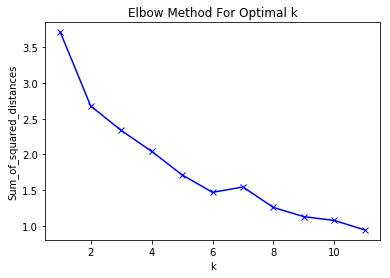

In [22]:
plt.plot(range(1,Ks), ssd, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

The cell below appends the cluster labels based on the pre-set "kclusters" variable to the chosen dataframe. Additionally, the first 5 rows of the appended dataframe is displayed.

In [23]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = toronto_df

toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,3,Coffee Shop,Park,Pub,Bakery,Breakfast Spot
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,3,Coffee Shop,Sushi Restaurant,Diner,Restaurant,Bar
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,3,Café,Clothing Store,Cosmetics Shop,Tea Room,Bakery
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,3,Café,Gastropub,Coffee Shop,Cosmetics Shop,Restaurant
4,M4E,East Toronto,The Beaches,43.676357,-79.293031,5,Trail,Health Food Store,Pub,Yoga Studio,Dance Studio


Based on the new dataframe, the clusters are mapped and color-coordinated based on the cluster they belong to. Based on the clustering, it is evident that, for the most part, the central region of Toronto belongs to the same cluster. This shows that central region of Toronto can be deemed as similar areas in terms of venue make-up.

In [24]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters